In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools

from tensorflow.keras.models import load_model
from scipy.io.wavfile import read as wav_read
from scipy.io.wavfile import write as wav_write
import scipy.signal as sps
from IPython.display import Javascript, HTML, Audio
import pyaudio

import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
import datasets
from datasets import load_dataset
from datasets.tasks import AutomaticSpeechRecognition
from faster_whisper import WhisperModel
import speech_recognition as sr

In [2]:
def get_language(prediction):
    index = tf.math.argmax(prediction).numpy()
    options = {0: "Noise", 1: "Chinese", 2: "English", 3: "French", 4: "German", 5: "Italian", 6: "Russian", 7: "Spanish"}
    return options[index]

def down_sample(audio, sampling_rate=48000, target_rate=16000):
    number_of_samples = round(len(audio) * float(target_rate) / sampling_rate)
    audio = sps.resample(audio, number_of_samples)
    return audio

def normalize(signal):
    maximum = max(abs(signal.max()), abs(signal.min()))
    if maximum == 0.0:
        print("normalize: omitting to divide by zero!!")
        return signal
    return signal / float(maximum)
 
def pad_or_cut(data, max_len):
    if len(data) == max_len:
        return data
    elif len(data) > max_len:
        return data[:max_len]
    else:
        to_add = max(max_len - len(data), 0)
        data = np.pad(data, (0, to_add), mode='constant', constant_values=0)
        return data

def pre_process(audio):
    # audio = down_sample(audio, sample_rate, target_sample_rate)     # input must be sampled at 16000kHz
    audio = normalize(audio)                    # input range is floating point from 0 to 1
    audio = pad_or_cut(audio, num_samples)      # input must be 80000
    audio = tf.expand_dims(audio, -1)           # add a channel for stft
    audio = tf.expand_dims(audio, 0)            # make it a batch
    return audio

In [4]:
fr = iter(load_dataset("facebook/multilingual_librispeech", "french", split="validation", streaming=True))
eng = iter(load_dataset("librispeech_asr", 'clean', split="validation", streaming=True))
# ger = iter(load_dataset("facebook/multilingual_librispeech", "german", split="validation", streaming=True))
# pol = iter(load_dataset("facebook/multilingual_librispeech", "polish", split="validation", streaming=True))

{'file': '2277-149896-0001.flac', 'audio': {'path': '2277-149896-0001.flac', 'array': array([ 0.00115967, -0.00042725,  0.00082397, ..., -0.00180054,
       -0.00192261, -0.00140381]), 'sampling_rate': 16000}, 'text': 'HE WOULD HAVE TO PAY HER THE MONEY WHICH SHE WOULD NOW REGULARLY DEMAND OR THERE WOULD BE TROUBLE IT DID NOT MATTER WHAT HE DID', 'speaker_id': 2277, 'chapter_id': 149896, 'id': '2277-149896-0001'}
(114320,) (7, 16000)


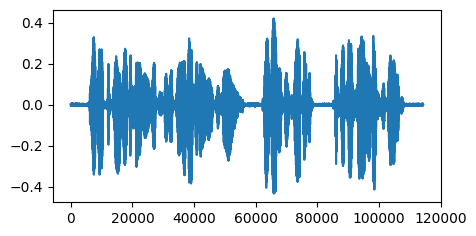

In [5]:
idx = 1
sample = next(itertools.islice(eng, idx, None))
sampling_rate = sample['audio']['sampling_rate']

x = sample['audio']['array']
x_batch = x[:(x.shape[0] // sampling_rate)*sampling_rate].reshape(-1,sampling_rate)

text = sample['text']
print(sample)
print(x.shape, x_batch.shape)

plt.figure(figsize=(5,2.5))
plt.plot(x)
plt.show()

Audio(x, rate=sampling_rate, normalize=False)

# RNN transformer
https://github.com/zkmkarlsruhe/language-identification

In [19]:
# input restrictions
length_s = 5
sample_rate = 48000
num_samples = length_s * sampling_rate

model = load_model("model_17")

In [20]:
for X in x_batch:
    audio_processed = pre_process(X)
    prediction = model.predict(audio_processed)
    language = get_language(prediction[0])
    print(language)

1/1 [==============================] - 1s 1s/step
German
1/1 [==============================] - 0s 56ms/step
English
1/1 [==============================] - 0s 54ms/step
Italian
1/1 [==============================] - 0s 49ms/step
English
1/1 [==============================] - 0s 44ms/step
English
1/1 [==============================] - 0s 45ms/step
German
1/1 [==============================] - 0s 47ms/step
Italian


# Speech to text

In [26]:
from scipy.io.wavfile import write, read

write('audio.wav', sampling_rate, x)
sample_rate, frame_data = read("audio.wav")
sample_width = frame_data.itemsize
print(sample_width)
# r = sr.Recognizer()

8


In [28]:
%%time
recognizer = sr.Recognizer()
audio = sr.AudioData(x_batch[0], sampling_rate, 4)
text = recognizer.recognize_google(audio, language="en-US")
print(text)

new
CPU times: total: 31.2 ms
Wall time: 1.06 s


# OpenAI Whisper v3

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
model_id = "openai/whisper-large-v3"

model = AutoModelForSpeechSeq2Seq.from_pretrained(model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)
pipe = pipeline("automatic-speech-recognition", model=model, tokenizer=processor.tokenizer, feature_extractor=processor.feature_extractor, max_new_tokens=128, chunk_length_s=30, batch_size=16, return_timestamps=True, torch_dtype=torch_dtype, device=device,)

In [ ]:
%%time
input_data = sample['audio'].copy()
result = pipe(input_data)

print(result["text"])
print('#####')
print(text)

# Faster whisper

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = "float16" if torch.cuda.is_available() else "int8"

In [33]:
model_fast_large = WhisperModel("large-v3", device=device, compute_type=torch_dtype) # GPU with int8_float16 or CPU with INT8

In [13]:
%%time
input_data = sample['audio']['array'].copy()
segments, info = model_fast_large.transcribe(input_data, beam_size=5)
print("Detected language '%s' with probability %f" % (info.language, info.language_probability))

Detected language 'en' with probability 0.999727
CPU times: total: 1min 19s
Wall time: 20.4 s


In [14]:
%%time
print(list(segments))
# for segment in segments:
#     print("[%.2fs -> %.2fs] %s" % (segment.start, segment.end, segment.text))
print('#####')
print(text)

[Segment(id=1, seek=714, start=0.0, end=3.34, text=' He would have to pay her the money which she would now regularly demand,', tokens=[50365, 634, 576, 362, 281, 1689, 720, 264, 1460, 597, 750, 576, 586, 11672, 4733, 11, 50532], temperature=0.0, avg_logprob=-0.12374561542973798, compression_ratio=1.3, no_speech_prob=0.0010054042795673013, words=None), Segment(id=2, seek=714, start=3.7600000000000002, end=6.68, text=' or there would be trouble. It did not matter what he did.', tokens=[50553, 420, 456, 576, 312, 5253, 13, 467, 630, 406, 1871, 437, 415, 630, 13, 50699], temperature=0.0, avg_logprob=-0.12374561542973798, compression_ratio=1.3, no_speech_prob=0.0010054042795673013, words=None)]
#####
HE WOULD HAVE TO PAY HER THE MONEY WHICH SHE WOULD NOW REGULARLY DEMAND OR THERE WOULD BE TROUBLE IT DID NOT MATTER WHAT HE DID
CPU times: total: 32.8 s
Wall time: 8.33 s


In [6]:
model_fast_small = WhisperModel("small.en", device=device, compute_type=torch_dtype)

In [31]:
%%time
input_data = sample['audio']['array'].copy()
segments, info = model_fast_small.transcribe(input_data, beam_size=5, word_timestamps=True)
print("Detected language '%s' with probability %f" % (info.language, info.language_probability))

Detected language 'en' with probability 1.000000
CPU times: total: 62.5 ms
Wall time: 69.8 ms


In [32]:
%%time
print([i.text for i in segments])
# print(list(segment))
print('#####')
print(text)

[' He would have to pay her the money, which she would now regularly demand, or there would', ' be trouble.', ' It did not matter what he did.']
#####
HE WOULD HAVE TO PAY HER THE MONEY WHICH SHE WOULD NOW REGULARLY DEMAND OR THERE WOULD BE TROUBLE IT DID NOT MATTER WHAT HE DID
CPU times: total: 18.5 s
Wall time: 4.86 s


# Multilingual conversation detection

In [8]:
idx = 1
eng_sample = next(itertools.islice(eng, idx, None))
sampling_rate = eng_sample['audio']['sampling_rate']

x_eng = eng_sample['audio']['array']
eng_text = eng_sample['text']
Audio(x_eng, rate=sampling_rate, normalize=False)

In [10]:
idx = 1
fr_sample = next(itertools.islice(fr, idx, None))
sampling_rate = fr_sample['audio']['sampling_rate']

x_fr = fr_sample['audio']['array']
fr_text = fr_sample['text']
Audio(x_fr, rate=sampling_rate, normalize=False)

(190080,) (45440,) (235520,)


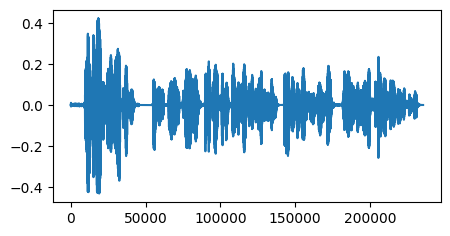

In [56]:
x_combined = np.hstack((x_eng, x_fr))
print(x_fr.shape, x_eng.shape, x_combined.shape)

plt.figure(figsize=(5,2.5))
plt.plot(x_combined)
plt.show()

Audio(x_combined, rate=sampling_rate, normalize=False)

In [64]:
%%time
segments, info = model_fast_small.transcribe(x_combined, beam_size=5, no_speech_threshold=2)

CPU times: total: 156 ms
Wall time: 169 ms


In [65]:
print("Detected language '%s' with probability %f" % (info.language, info.language_probability))

Detected language 'en' with probability 1.000000


In [66]:
%%time
print([i.text for i in segments])
print('###########')
print(eng_text, fr_text)

[' He also thought of his managerial position.']
###########
HE ALSO THOUGHT OF HIS MANAGERIAL POSITION ainsi l'idée d'évêché était pour la première fois mêlée avec celle de julien dans la tête d'une femme qui tôt ou tard devait distribuer les plus belles places de l'église de france
CPU times: total: 19.1 s
Wall time: 5.44 s


In [39]:
%%time
segments, info = model_fast_large.transcribe(x_combined, beam_size=5)

CPU times: total: 1min 24s
Wall time: 25.1 s


In [36]:
%%time
print([i.text for i in segments])
print('###########')
print(eng_text, fr_text)

[" ainsi l'idée d'évêcher était pour la première fois mêlée avec celle de julien dans la tête d'une femme qui tôt ou tard devait distribuer les plus belles places de l'église de france"]
###########
HE ALSO THOUGHT OF HIS MANAGERIAL POSITION ainsi l'idée d'évêché était pour la première fois mêlée avec celle de julien dans la tête d'une femme qui tôt ou tard devait distribuer les plus belles places de l'église de france
CPU times: total: 52.7 s
Wall time: 15.6 s


In [40]:
list(segments)

[Segment(id=1, seek=1472, start=0.0, end=16.68, text=" ainsi l'idée d'évêcher était pour la première fois mêlée avec celle de julien dans la tête d'une femme qui tôt ou tard devait distribuer les plus belles places de l'église de france", tokens=[50365, 26552, 287, 6, 34281, 274, 6, 26375, 1307, 6759, 11806, 2016, 635, 17872, 9576, 275, 1307, 75, 3856, 4163, 25722, 368, 30764, 1053, 2680, 635, 24661, 274, 6, 2613, 27427, 1956, 256, 8775, 2820, 21057, 1905, 1001, 4400, 5486, 1512, 1804, 4549, 279, 3190, 368, 287, 6, 526, 7191, 908, 368, 431, 719, 51199], temperature=0.0, avg_logprob=-0.08136624936014414, compression_ratio=1.3546099290780143, no_speech_prob=0.003344462951645255, words=None)]

In [ ]:
sys.exit()

# Deepspeech

# Real time streaming

In [ ]:
# import pyaudio
# import wave
# import sys
# import collections

# window_size = 10  # last 10 data points
# window = collections.deque(maxlen=window_size)

# window.append(new_data_point)
# audio_processed = pre_process(window)
# prediction = model.predict(audio_processed)
# language = get_language(prediction[0])
# print(language)
# prediction = predict(window)